**Table of contents**<a id='toc0_'></a>    
- [Adverse Events Classification Pipeline - Introduction](#toc1_)    
  - [Task 1: Clustering Adverse Events](#toc1_1_)    
  - [Task 2: Predicting Adverse Event Classes](#toc1_2_)    
  - [Model Deployment](#toc1_3_)    
- [Import Libraries](#toc2_)    
- [Load data](#toc3_)    
- [Process adverse events](#toc4_)    
- [Task 1: Creating meaningful groups](#toc5_)    
    - [Load RoBERTa](#toc5_1_1_)    
    - [Explore token sizes](#toc5_1_2_)    
    - [Embeddings](#toc5_1_3_)    
    - [Split the data](#toc5_1_4_)    
    - [Generate embeddings](#toc5_1_5_)    
    - [Normalize embeddings](#toc5_1_6_)    
    - [Perform UMAP dimensionality reduction](#toc5_1_7_)    
    - [Plot training, validation and test set distribution in UMAP Space](#toc5_1_8_)    
    - [Outlier Detection with Isolation Forest](#toc5_1_9_)    
    - [Remove outliers from dataframes](#toc5_1_10_)    
    - [Perform clustering, calculate labels and best_n_clusters](#toc5_1_11_)    
    - [Assign best n clusters to config](#toc5_1_12_)    
    - [Assign test and validation set clusters to dataframes](#toc5_1_13_)    
    - [Inspect clusters](#toc5_1_14_)    
    - [Plot clusters](#toc5_1_15_)    
- [Task 2: Predict Classes](#toc6_)    
    - [Check distributions](#toc6_1_1_)    
    - [Modeling](#toc6_1_2_)    
      - [Random Forest](#toc6_1_2_1_)    
      - [Make the pipeline](#toc6_1_2_2_)    
      - [Without using drug names](#toc6_1_2_3_)    
      - [Using drug names](#toc6_1_2_4_)    
- [Model Performance Analysis](#toc7_)    
      - [Without drug names](#toc7_1_1_1_)    
      - [With drug names](#toc7_1_1_2_)    
- [Future improvements](#toc8_)    
- [Inference example](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Adverse Events Classification Pipeline - Introduction](#toc0_)

## <a id='toc1_1_'></a>[Task 1: Clustering Adverse Events](#toc0_)
The approach combines NLP and dimensionality reduction techniques to create meaningful groups of adverse events. The pipeline uses:
1. RoBERTa embeddings to convert text descriptions into high-dimensional vectors
2. UMAP for dimensionality reduction
3. Isolation Forest for outlier detection to improve cluster quality
4. K-means clustering with silhouette score optimization to determine optimal number of clusters
This methodology is domain-agnostic and can be applied to other text clustering tasks.

## <a id='toc1_2_'></a>[Task 2: Predicting Adverse Event Classes](#toc0_)
The classification pipeline uses a nested cross-validation approach:
1. Outer loop (5-fold) for model evaluation
2. Inner loop (3-fold) for hyperparameter optimization
3. RandomForest classifier with class balancing
4. Option to include drug names as additional drug features

Performance metrics show good results (F1 score ~0.86 without drug names), suggesting good generalization while avoiding overfitting. The pipeline includes train/validation/test splits and maintains data separation throughout all preprocessing steps.

## <a id='toc1_3_'></a>[Model Deployment](#toc0_)
The pipeline includes a complete inference setup with:
- Model saving/loading functionality
- Preprocessing pipeline matching training configuration
- Outlier detection for identifying unusual cases
- Option to include/exclude drug name features

# <a id='toc2_'></a>[Import Libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List
from sklearn.metrics import silhouette_score
import hdbscan
from umap import UMAP
import seaborn as sns
import warnings
import os
from dataclasses import dataclass, field

os.environ["TOKENIZERS_PARALLELISM"] = "false"

warnings.filterwarnings("ignore", category=UserWarning, module="umap")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")


/Users/lucijagregov/Documents/projects/bank/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <a id='toc3_'></a>[Load data](#toc0_)

In [2]:
with open('../data/entity-extraction-data.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame([json.loads(d['output']) for d in data]).join(
    pd.Series([d['input'] for d in data], name='input')
)
df

,drug_name,adverse_events,input
0,Lipitor,"[persistent metallic taste, unpleasant taste]",Daniel Clark\ndaniel.clark@example.com\n666 El...
1,Neupogen,"[numbness, tingling]",Olivia Turner\nolivia.turner@example.com\n123 ...
2,Enbrel,"[persistent cough, difficulty breathing]","Emily Anderson,\nemily.anderson@email.com\n456..."
3,Humira,[significant weight loss],Liam Clark\nliam.clark@example.com\n345 Oak Av...
4,Cymbalta,"[increased irritability, restlessness]",Isabella Clark\nisabellac@example.com\n890 Elm...
...,...,...,...
754,Amlodipine,"[severe dizziness, swelling in ankles]","Hannah Lee,\nhannah.lee@example.com\n1122 Ceda..."
755,Singulair,[skin rash],Mason Hall\nmason.hall@email.com\n234 Pine Roa...
756,Ambien,"[loss of coordination, muscle pain]","Emily Johnson,\nemily.johnson@example.com\n910..."
757,Cialis,"[muscle pain, back pain]","Tom Sanders,\ntomsanders@example.com\n5678 Oak..."


# <a id='toc4_'></a>[Process adverse events](#toc0_)

In [3]:
num_unique_rows = df['adverse_events'].apply(lambda x: tuple(sorted(x))).nunique()
num_unique_rows


616

In [4]:
df.drop('adverse_events', axis=1).nunique()

drug_name     50
input        735
dtype: int64

In [5]:
df['input'].iloc[0]

"Daniel Clark\ndaniel.clark@example.com\n666 Elm Street, Denver, CO 80201\n3035551111, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I've been prescribed Lipitor, and I've noticed a persistent metallic taste in my mouth. It's quite unpleasant, and I'm concerned about this taste being related to the medication. Can you provide some guidance?"

In [6]:
df['input'].iloc[1]

'Olivia Turner\nolivia.turner@example.com\n123 Birch Avenue, Denver, CO 80201\n3035552345, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: After Neupogen, I developed numbness and tingling. Is this related to the medication?'

In [7]:
df['processed_adverse_events'] = df['adverse_events'].apply(lambda x: ' '.join(x))
df

,drug_name,adverse_events,input,processed_adverse_events
0,Lipitor,"[persistent metallic taste, unpleasant taste]",Daniel Clark\ndaniel.clark@example.com\n666 El...,persistent metallic taste unpleasant taste
1,Neupogen,"[numbness, tingling]",Olivia Turner\nolivia.turner@example.com\n123 ...,numbness tingling
2,Enbrel,"[persistent cough, difficulty breathing]","Emily Anderson,\nemily.anderson@email.com\n456...",persistent cough difficulty breathing
3,Humira,[significant weight loss],Liam Clark\nliam.clark@example.com\n345 Oak Av...,significant weight loss
4,Cymbalta,"[increased irritability, restlessness]",Isabella Clark\nisabellac@example.com\n890 Elm...,increased irritability restlessness
...,...,...,...,...
754,Amlodipine,"[severe dizziness, swelling in ankles]","Hannah Lee,\nhannah.lee@example.com\n1122 Ceda...",severe dizziness swelling in ankles
755,Singulair,[skin rash],Mason Hall\nmason.hall@email.com\n234 Pine Roa...,skin rash
756,Ambien,"[loss of coordination, muscle pain]","Emily Johnson,\nemily.johnson@example.com\n910...",loss of coordination muscle pain
757,Cialis,"[muscle pain, back pain]","Tom Sanders,\ntomsanders@example.com\n5678 Oak...",muscle pain back pain


In [8]:
df.processed_adverse_events.unique()[:10]

array(['persistent metallic taste unpleasant taste', 'numbness tingling',
       'persistent cough difficulty breathing', 'significant weight loss',
       'increased irritability restlessness', 'trouble breathing fever',
       'unexplained muscle tenderness difficulty climbing stairs',
       'white patches in mouth pain when swallowing',
       'frequent nosebleeds heavy menstrual periods impact on daily life',
       'pain at injection site redness at injection site'], dtype=object)

Checking all unique values didn't show that any cleaning is necessary or preprocessing so I will skip that.

In [9]:
df.isna().sum()

drug_name                   0
adverse_events              0
input                       0
processed_adverse_events    0
dtype: int64

# <a id='toc5_'></a>[Task 1: Creating meaningful groups](#toc0_)

The provided dataset contains a collection of adverse_events. There are over 100 unique entries. Your first task is to programmatically combine the entries into meaningful groups. Please aim for no more than 30 groups in total. (N.B.: The final grouping does not need to be perfect, but your methodology should be sound and your code should be transferable to a different domain.)

I will use roberta as a general model.

### <a id='toc5_1_1_'></a>[Load RoBERTa](#toc0_)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModel.from_pretrained("distilroberta-base")

tokenizer.save_pretrained("../distilroberta-base")
model.save_pretrained("../distilroberta-base")

tokenizer = AutoTokenizer.from_pretrained("../distilroberta-base")
model = AutoModel.from_pretrained("../distilroberta-base")

### <a id='toc5_1_2_'></a>[Explore token sizes](#toc0_)

In [11]:
text_list = df.processed_adverse_events
text_list

0      persistent metallic taste unpleasant taste
1                               numbness tingling
2           persistent cough difficulty breathing
3                         significant weight loss
4             increased irritability restlessness
                          ...                    
754           severe dizziness swelling in ankles
755                                     skin rash
756              loss of coordination muscle pain
757                         muscle pain back pain
758          significant weight loss night sweats
Name: processed_adverse_events, Length: 759, dtype: object

How it would look like on the first 2 sentences (rows):

In [12]:
for text in text_list[:3]:
    print(text)
    inputs = tokenizer(text, return_tensors="pt", padding=False, truncation=False)
    print(inputs)

persistent metallic taste unpleasant taste
{'input_ids': tensor([[    0, 16414, 21464, 24117,  5840, 26262,  5840,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
numbness tingling
{'input_ids': tensor([[   0,  282, 4179, 1825,  326,  154, 1527,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
persistent cough difficulty breathing
{'input_ids': tensor([[    0, 16414, 21464, 21768,  9600,  9589,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


Here 0 and 2 are special tokens that mark start and end of the sentence.

For all of the rows:

In [13]:
def calculate_token_lengths(text_list):
    """
    Tokenizes input text and calculates token lengths for each row.
    Args:
        text_list (list of str): List of text strings to tokenize.
    Returns:
        list of int: Token lengths for each text string.
    """
    token_lengths = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors="pt", padding=False, truncation=False)
        token_lengths.append(len(inputs["input_ids"][0]))
    return token_lengths

In [14]:
def analyze_token_lengths(token_lengths):
    """
    Analyze and visualize token length statistics.
    Args:
        token_lengths (list of int): Token lengths for each text string.
    Returns:
        dict: Statistical metrics for token lengths.
    """
    stats = {
        "min": np.min(token_lengths),
        "max": np.max(token_lengths),
        "mean": np.mean(token_lengths),
        "median": np.median(token_lengths),
        "90th_percentile": np.percentile(token_lengths, 90),
        "95th_percentile": np.percentile(token_lengths, 95),
        "99th_percentile": np.percentile(token_lengths, 99)
    }
    print("Token Length Statistics:", stats)

    plt.hist(token_lengths, bins=30, alpha=0.7, color="blue")
    plt.title("Distribution of Token Lengths")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.axvline(stats["95th_percentile"], color="red", linestyle="dashed", linewidth=1, label="95th Percentile")
    plt.legend()
    plt.show()
    
    return stats

Token Length Statistics: {'min': 4, 'max': 21, 'mean': 7.899868247694335, 'median': 7.0, '90th_percentile': 11.0, '95th_percentile': 12.0, '99th_percentile': 14.419999999999959}


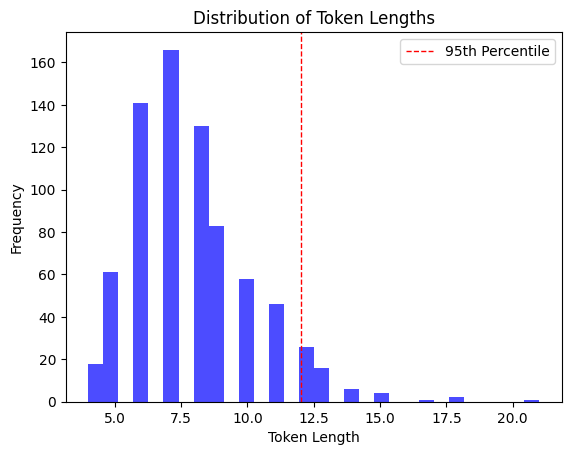

In [15]:
token_lengths = calculate_token_lengths(df['processed_adverse_events'].tolist())
token_stats = analyze_token_lengths(token_lengths)

Max number of tokens is 21. I will dynamically calculate this in the code and compare to max token length.

In [16]:
optimal_max_length = int(token_stats["max"])
print(f"Max_length: {optimal_max_length}")

Max_length: 21


### <a id='toc5_1_3_'></a>[Embeddings](#toc0_)

In [17]:
@dataclass
class Config:
    # Basic config
    model_name: str = "../distilroberta-base"
    batch_size: int = 32
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    pooling_strategy: str = "mean"
    random_state: int = 27
    
    # UMAP config
    n_components: int = 2
    n_neighbors: int = 10
    min_dist: float = 0.05
    metric: str = 'cosine'
    n_jobs: int = -1
    
    # Clustering config
    clustering_method: str = 'kmeans'
    n_clusters: int = 15
    min_cluster_size: int = 5
    min_samples: int = 5
    kmeans_n_init: int = 50
    kmeans_max_iter: int = 1000
    hdbscan_metric: str = 'euclidean'
    
    # HDBSCAN parameter ranges
    hdbscan_min_cluster_size_range: range = field(default_factory=lambda: range(2, 30))
    hdbscan_min_samples_range: List[int] = field(default_factory=lambda: [2, 3, 4, 5])
    
    # Experiment config
    cluster_range: range = field(default_factory=lambda: range(5, 20))

class EmbeddingGenerator:
    def __init__(self, config: Config):
        self.config = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.model = AutoModel.from_pretrained(config.model_name)
        self.device = torch.device(config.device)
        self.model.to(self.device)

    def calculate_max_length(self, texts: List[str]) -> int:
        tokenized = self.tokenizer(
            texts, padding=False, truncation=False, return_length=True
        )
        return max(tokenized['length'])

    def _pool_embeddings(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        if self.config.pooling_strategy == "cls":
            return hidden_states[:, 0]
        elif self.config.pooling_strategy == "mean":
            attention_mask = attention_mask.unsqueeze(-1)
            return torch.sum(hidden_states * attention_mask, dim=1) / attention_mask.sum(dim=1).clamp(min=1e-9)
        else:
            raise ValueError("Unsupported pooling strategy.")

    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        max_length = self.calculate_max_length(texts)
        embeddings = []
        for i in range(0, len(texts), self.config.batch_size):
            batch_texts = texts[i:i + self.config.batch_size]
            batch_encoding = self.tokenizer(
                batch_texts,
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            input_ids = batch_encoding['input_ids'].to(self.device)
            attention_mask = batch_encoding['attention_mask'].to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
                pooled = self._pool_embeddings(outputs.last_hidden_state, attention_mask)
                embeddings.append(pooled.cpu().numpy())

        return np.vstack(embeddings)


def inspect_clusters(df: pd.DataFrame, cluster_column: str, text_column: str, n_clusters: int):
    """
    Inspects the content of each cluster.
    
    Args:
        df (pd.DataFrame): DataFrame containing clustering results.
        cluster_column (str): Column name with cluster assignments.
        text_column (str): Column name with the original text.
        n_clusters (int): Number of clusters.
    """
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:")
        print(df[df[cluster_column] == cluster][text_column].shape)
        print(df[df[cluster_column] == cluster][text_column].head(10))  # Print top 10 samples per cluster


def plot_clusters(embeddings: np.ndarray, labels: np.ndarray, title: str = "Cluster Visualization"):
    """
    Plots clusters in 2D space using UMAP-reduced embeddings.
    
    Args:
        embeddings (np.ndarray): UMAP-reduced embeddings.
        labels (np.ndarray): Cluster labels.
        title (str): Plot title.
    """
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        hue=labels,
        palette="tab10",
        s=30,
        legend="full"
    )
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Cluster")
    plt.show()


### <a id='toc5_1_4_'></a>[Split the data](#toc0_)

In [18]:
column_to_cluster = 'processed_adverse_events'
text_data = df[column_to_cluster].tolist()
print(f'First 5 processed_adverse_events: {text_data[:5]}')

config=Config()

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=config.random_state
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=config.random_state
)

# Confirm indexes don't repeat between train/val/test:
assert set(train_df.index).intersection(val_df.index) == set()
assert set(test_df.index).intersection(val_df.index) == set()
assert set(train_df.index).intersection(test_df.index) == set()

First 5 processed_adverse_events: ['persistent metallic taste unpleasant taste', 'numbness tingling', 'persistent cough difficulty breathing', 'significant weight loss', 'increased irritability restlessness']


### <a id='toc5_1_5_'></a>[Generate embeddings](#toc0_)

In [19]:
embedding_generator = EmbeddingGenerator(config)

print("Generating embeddings for training set...")
train_embeddings = embedding_generator.generate_embeddings(train_df[column_to_cluster].tolist())

print("Generating embeddings for validation set...")
val_embeddings = embedding_generator.generate_embeddings(val_df[column_to_cluster].tolist())

print("Generating embeddings for test set...")
test_embeddings = embedding_generator.generate_embeddings(test_df[column_to_cluster].tolist())

print(f'\nTrain embeddings shape: {train_embeddings.shape}')
print(f'Val embeddings shape: {val_embeddings.shape}')
print(f'test embeddings shape: {test_embeddings.shape}')

Generating embeddings for training set...
Generating embeddings for validation set...
Generating embeddings for test set...

Train embeddings shape: (485, 768)
Val embeddings shape: (122, 768)
test embeddings shape: (152, 768)


We have a lot more features than we have rows, i.e. a high dimensional embeddings on a small data. This could lead to overfitting and dimensionality reduction might help wth this.

In [20]:
def basic_embedding_stats(embeddings):
    print(embeddings.min())
    print(embeddings.max())
    print(embeddings.mean())

print('Train embeddings min/max/mean:')
basic_embedding_stats(train_embeddings)
print('\nVal embeddings min/max/mean:')
basic_embedding_stats(val_embeddings)
print('\nTest embeddings min/max/mean:')
basic_embedding_stats(test_embeddings)

Train embeddings min/max/mean:
-6.6139317
13.038768
0.02440135

Val embeddings min/max/mean:
-6.0509443
12.785152
0.024420958

Test embeddings min/max/mean:
-6.3942633
13.164839
0.0244593


I will normalize embeddings before clustering because clustering methods like KMeans and hdbscan rely on distance metrics.

### <a id='toc5_1_6_'></a>[Normalize embeddings](#toc0_)

In [21]:
train_norm = train_embeddings / np.linalg.norm(train_embeddings, axis=1)[:, np.newaxis]
val_norm = val_embeddings / np.linalg.norm(val_embeddings, axis=1)[:, np.newaxis]
test_norm = test_embeddings / np.linalg.norm(test_embeddings, axis=1)[:, np.newaxis]

print('Normalized train embeddings min/max/mean:')
basic_embedding_stats(train_norm)
print('\nNormalized val embeddings min/max/mean:')
basic_embedding_stats(val_norm)
print('\nNormalized test embeddings min/max/mean:')
basic_embedding_stats(test_norm)

Normalized train embeddings min/max/mean:
-0.49948528
0.9638611
0.0018341448

Normalized val embeddings min/max/mean:
-0.4588515
0.9617448
0.0018362257

Normalized test embeddings min/max/mean:
-0.48414904
0.9606201
0.0018400163


### <a id='toc5_1_7_'></a>[Perform UMAP dimensionality reduction](#toc0_)

UMAP reduces the dimensionality while preserving the structure of the data, making clustering more effective. UMAP focuses on preserving local and global structure which is better for clustering to comparing to PCA which focuses on global variance of the data and might oversimplify.

In [22]:
from umap import UMAP

config = Config(
    n_components=2,
    n_neighbors=10,
    min_dist=0.05,
    metric='cosine'
)

umap = UMAP(
    n_components=config.n_components,
    n_neighbors=config.n_neighbors,
    min_dist=config.min_dist,
    metric=config.metric,
    random_state=config.random_state
)

train_reduced = umap.fit_transform(train_norm)
# Transform validation and test embeddings using the same UMAP model
val_reduced = umap.transform(val_norm)
test_reduced = umap.transform(test_norm)

print(train_reduced.shape)
print(val_reduced.shape)
print(test_reduced.shape)

(485, 2)
(122, 2)
(152, 2)


### <a id='toc5_1_8_'></a>[Plot training, validation and test set distribution in UMAP Space](#toc0_)

In [23]:
def plot_reduced(train_reduced, val_reduced, test_reduced):
    plt.scatter(val_reduced[:, 0], val_reduced[:, 1], c='blue', label='Validation Set')
    plt.scatter(train_reduced[:, 0], train_reduced[:, 1], c='orange', label='Training Set', alpha=0.5)
    plt.scatter(test_reduced[:, 0], test_reduced[:, 1], c='green', label='Test Set', alpha=0.5)
    plt.title("Training, validation and test set distribution in UMAP Space")
    plt.legend()
    plt.show()

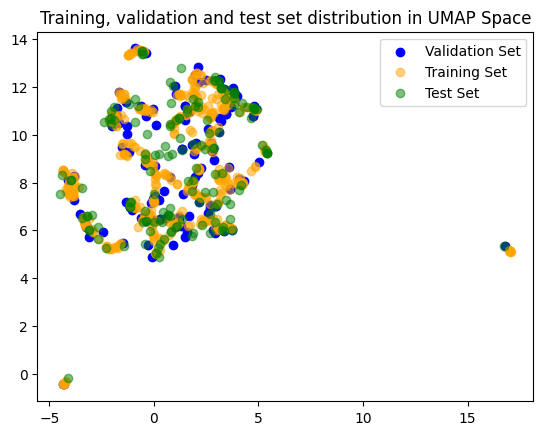

In [24]:
plot_reduced(train_reduced, val_reduced, test_reduced)

There are some outliers on the edges which might affect clustering. I will remove those outliers using Isolation Forest. The Isolation Forest assigns a value (1 for inliers and -1 for outliers) to each data point based on its isolation score. A point labeled as 1 is an inlier, which means it is consistent with the distribution of the rest of the dataset (not an outlier).

### <a id='toc5_1_9_'></a>[Outlier Detection with Isolation Forest](#toc0_)

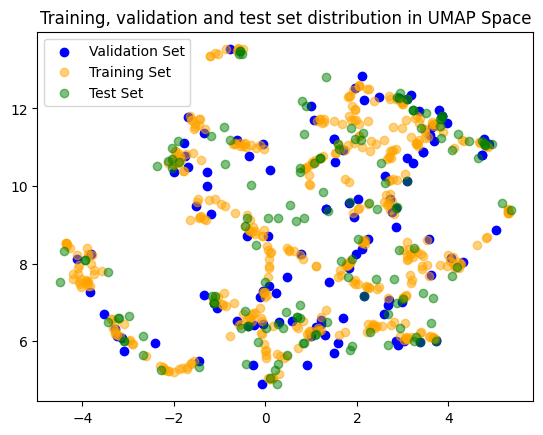

In [25]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=config.random_state)

iso_forest.fit(train_reduced)

train_inliers = iso_forest.predict(train_reduced) == 1
val_inliers = iso_forest.predict(val_reduced) == 1
test_inliers = iso_forest.predict(test_reduced) == 1

train_reduced_clean = train_reduced[train_inliers]
val_reduced_clean = val_reduced[val_inliers]
test_reduced_clean = test_reduced[test_inliers]

plot_reduced(train_reduced_clean, val_reduced_clean, test_reduced_clean)

This looks better.

In [26]:
print(train_reduced.shape)
print(train_reduced_clean.shape)

(485, 2)
(460, 2)


In [27]:
print(val_reduced.shape)
print(val_reduced_clean.shape)

(122, 2)
(117, 2)


In [28]:
print(test_reduced.shape)
print(test_reduced_clean.shape)

(152, 2)
(146, 2)


Some data was lost, 25 points for the training set, 5 for validation and 6 for test set. This could probably be optimised with better hyperparamters.

### <a id='toc5_1_10_'></a>[Remove outliers from dataframes](#toc0_)

In [29]:
train_df_clean = train_df[train_inliers]
val_df_clean = val_df[val_inliers]
test_df_clean = test_df[test_inliers]

In [30]:
assert train_df_clean.shape[0] == train_reduced_clean.shape[0]
assert val_df_clean.shape[0] == val_reduced_clean.shape[0]
assert test_df_clean.shape[0] == test_reduced_clean.shape[0]

### <a id='toc5_1_11_'></a>[Perform clustering, calculate labels and best_n_clusters](#toc0_)

In [31]:
from typing import Tuple
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from typing import Tuple
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def perform_clustering(
    train_data: np.ndarray,
    val_data: np.ndarray,
    test_data: np.ndarray,
    config: Config
) -> Tuple:
    """
    Perform clustering on train data and predict cluster labels for validation and test data.
    
    Args:
        train_data (np.ndarray): Cleaned and reduced training data.
        val_data (np.ndarray): Cleaned and reduced validation data.
        test_data (np.ndarray): Cleaned and reduced test data.
        config (Config): Configuration object for clustering parameters.

    Returns:
        Tuple: (clustering_model, train_labels, val_labels, test_labels)
    """
    clustering_model = None
    train_labels = None
    val_labels = None
    test_labels = None

    if config.clustering_method == "hdbscan":
        clustering_model = hdbscan.HDBSCAN(
            min_cluster_size=config.min_cluster_size,
            metric=config.hdbscan_metric,
            core_dist_n_jobs=config.n_jobs,
            prediction_data=True
        )
        train_labels = clustering_model.fit_predict(train_data)
        print(f"Number of clusters (HDBSCAN): {len(set(train_labels)) - (1 if -1 in train_labels else 0)}")

        val_labels, _ = hdbscan.approximate_predict(clustering_model, val_data)
        test_labels, _ = hdbscan.approximate_predict(clustering_model, test_data)
        
        return clustering_model, train_labels, val_labels, test_labels
    elif config.clustering_method == "kmeans":
        best_n_clusters = None
        best_silhouette_score = -1
        best_model = None

        for n_clusters in config.cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=config.random_state)
            labels = kmeans.fit_predict(train_data)

            if len(set(labels)) > 1:  # Must have more than 1 cluster
                score = silhouette_score(train_data, labels)
                if score > best_silhouette_score:
                    best_silhouette_score = score
                    best_n_clusters = n_clusters
                    best_model = kmeans

        print(f"Best number of clusters (KMeans): {best_n_clusters} with Silhouette Score: {best_silhouette_score:.4f}")

        if best_model is None:
            raise ValueError("No valid clustering configuration found for KMeans")

        clustering_model = best_model
        train_labels = clustering_model.predict(train_data)

        val_labels = clustering_model.predict(val_data)
        test_labels = clustering_model.predict(test_data)

        return clustering_model, best_n_clusters, train_labels, val_labels, test_labels
    else:
        raise ValueError("Unsupported clustering method")

In [32]:
clustering_model, best_n_clusters, train_labels, val_labels, test_labels = perform_clustering(
    train_reduced_clean, 
    val_reduced_clean, 
    test_reduced_clean, 
    config
)

Best number of clusters (KMeans): 19 with Silhouette Score: 0.5493


This Silhouette score isn't perfect (close to 1), but for medical data it might be good enough since it is hard to achieve perfect or close to perfect separation due to overlapping symptoms. I will inspect clusters in detail below. This is very sensitive to UMAP parameters, so they should ideally be optimised, but I will leave it at this for the purposes of this task.

In [33]:
best_n_clusters

19

### <a id='toc5_1_12_'></a>[Assign best n clusters to config](#toc0_)

In [34]:
config.n_clusters = best_n_clusters
config.n_clusters

19

### <a id='toc5_1_13_'></a>[Assign test and validation set clusters to dataframes](#toc0_)

In [35]:
train_df_clean.loc[:, f"best_clusters_{config.n_clusters}"] = train_labels
val_df_clean.loc[:, f"best_clusters_{config.n_clusters}"] = val_labels
test_df_clean.loc[:, f"best_clusters_{config.n_clusters}"] = test_labels

display(train_df_clean.head())
display(val_df_clean.head())
display(test_df_clean.head())

/var/folders/pk/p4tz0gf96l113931p5pw8d6c0000gp/T/ipykernel_14800/2856181120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_clean.loc[:, f"best_clusters_{config.n_clusters}"] = train_labels
/var/folders/pk/p4tz0gf96l113931p5pw8d6c0000gp/T/ipykernel_14800/2856181120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_clean.loc[:, f"best_clusters_{config.n_clusters}"] = val_labels
/var/folders/pk/p4tz0gf96l113931p5pw8d6c0000gp/T/ipykernel_14800/2856181120.py:3: SettingWithCopyWarning: 
A v

,drug_name,adverse_events,input,processed_adverse_events,best_clusters_19
705,Neupogen,[sudden chest pain],Liam Johnson\nliam.johnson@example.com\n101 Oa...,sudden chest pain,4
347,Epogen,"[fever, cough]",Noah Wilson\nnoah.wilson@example.com\n789 Ceda...,fever cough,18
470,AndroGel,"[painful erections, discomfort]","Ryan Taylor,\nrtaylor@example.com\n2020 Willow...",painful erections discomfort,13
250,Vytorin,"[tremors, nervousness]",Lily Parker\nlily.parker@email.com\n789 Maple ...,tremors nervousness,1
686,Aranesp,"[swelling in arms and legs, difficulty breathing]","Patricia Wilson,\npwilson@example.com\n12121 O...",swelling in arms and legs difficulty breathing,9


,drug_name,adverse_events,input,processed_adverse_events,best_clusters_19
747,Symbicort,[feeling light-headed],Oliver Turner\noliver.turner@email.com\n987 Pi...,feeling light-headed,12
632,Staxyn,[irregular heartbeat],Henry Adams\nhenry.adams@email.com\n123 Birch ...,irregular heartbeat,3
118,Provigil,"[severe anxiety, suicidal thoughts]",Isabella Martinez\nisabella.martinez@email.com...,severe anxiety suicidal thoughts,10
673,Lunesta,"[persistent headache, unusual taste in mouth]",Sarah Davis\nsarah.davis@example.com\n123 Elm ...,persistent headache unusual taste in mouth,18
100,Prilosec,"[hives, difficulty breathing]",Emily Davis\nemily.davis@email.com\n456 Oak St...,hives difficulty breathing,15


,drug_name,adverse_events,input,processed_adverse_events,best_clusters_19
127,Abilify,"[severe drowsiness, dizziness]","Laura Davis,\nldavis@example.com\n1212 Birch L...",severe drowsiness dizziness,3
31,Viagra,"[swelling in hands, swelling in feet]","Sophia Johnson,\nsophia.johnson@example.com\n4...",swelling in hands swelling in feet,9
608,Cialis,[prolonged erections (lasting more than 4 hours)],"Charles Martinez,\ncmartinez@example.com\n9090...",prolonged erections (lasting more than 4 hours),2
563,Singulair,"[stomach pain, diarrhea]",Sarah Johnson\nsarah.johnson@email.com\n45 Elm...,stomach pain diarrhea,4
496,Prilosec,"[sore throat, headache]",Aiden Harris\naiden.harris@email.com\n789 Mapl...,sore throat headache,18


### <a id='toc5_1_14_'></a>[Inspect clusters](#toc0_)

In [36]:
inspect_clusters(train_df_clean, f"best_clusters_{config.n_clusters}", column_to_cluster, config.n_clusters)


Cluster 0:
(34,)
289                     severe headache pale skin
534                      severe skin rash itching
389                          persistent skin rash
396    persistent skin rash itchy rash discomfort
714       severe skin rash blistering and peeling
569          fever joint pain skin rash on cheeks
96                            new growths on skin
109               persistent skin rash joint pain
472              severe skin rash blistering skin
163                      severe skin rash itching
Name: processed_adverse_events, dtype: object

Cluster 1:
(25,)
250                                  tremors nervousness
217                             muscle movements tremors
112                                  tremors nervousness
191    severe headaches burning sensation when urinating
159                               tremors muscle shaking
606                       tremors feeling of nervousness
503             muscle weakness difficulty concentrating
355              se

In [37]:
inspect_clusters(val_df_clean, f"best_clusters_{config.n_clusters}", column_to_cluster, config.n_clusters)


Cluster 0:
(3,)
339               severe skin rash itching
139        itchy skin rash scaly skin rash
558    persistent skin rash joint swelling
Name: processed_adverse_events, dtype: object

Cluster 1:
(11,)
497                       joint pain nausea weight loss
710                        tremors loss of coordination
215                     joint swelling muscle stiffness
511                                  indigestion nausea
484                     painful urination muscle spasms
188                      joint swelling joint stiffness
297                                  nosebleeds tremors
535      muscle stiffness uncontrolled muscle movements
568                           mood changes restlessness
427    severe nervous system reactions tremors sweating
Name: processed_adverse_events, dtype: object

Cluster 2:
(4,)
304         severe muscle weakness in shoulders and neck
144    increase in muscle pain difficulty in moving j...
696    severe nervous system reactions muscle rigidit

In [38]:
inspect_clusters(test_df_clean, f"best_clusters_{config.n_clusters}", column_to_cluster, config.n_clusters)


Cluster 0:
(5,)
677                        skin rash worsens in sunlight
749    unusual itching persistent rash at injection site
383                        skin rash worsens in sunlight
419                   itching blisters breakdown of skin
367                              darkening of skin color
Name: processed_adverse_events, dtype: object

Cluster 1:
(8,)
227                       muscle pain muscle weakness
572    muscle stiffness uncontrolled muscle movements
220                  tremors jerking muscle movements
753                                        rash itchy
461                   painful urination muscle spasms
66                fluttering in chest muscle weakness
295                            tremors muscle shaking
223        severe tingling sensations muscle weakness
Name: processed_adverse_events, dtype: object

Cluster 2:
(4,)
608      prolonged erections (lasting more than 4 hours)
103                     weakness on one side of the body
649    severe tingling mus

Some clusters only consist of 1 sentence, so we will have imbalanced data for our modeling.

### <a id='toc5_1_15_'></a>[Plot clusters](#toc0_)

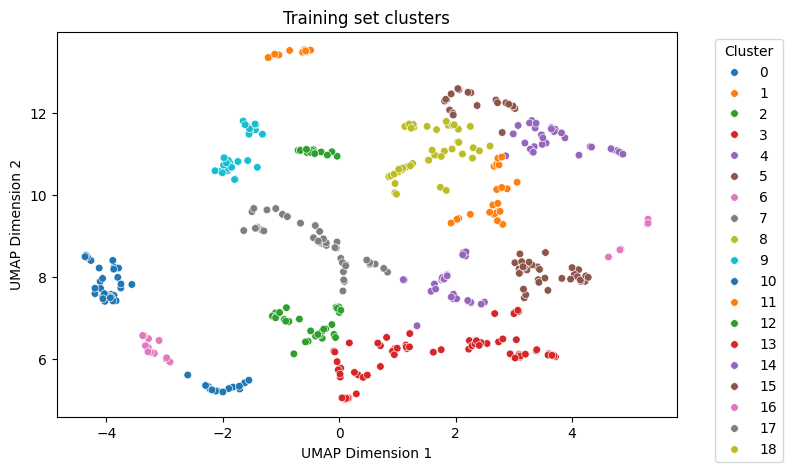

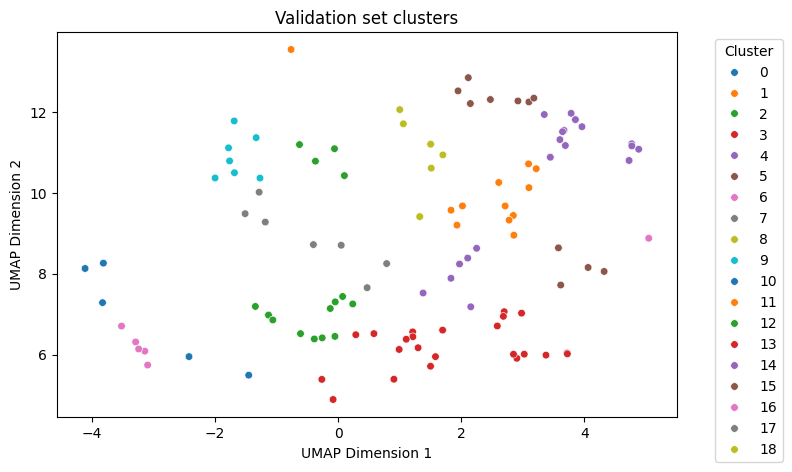

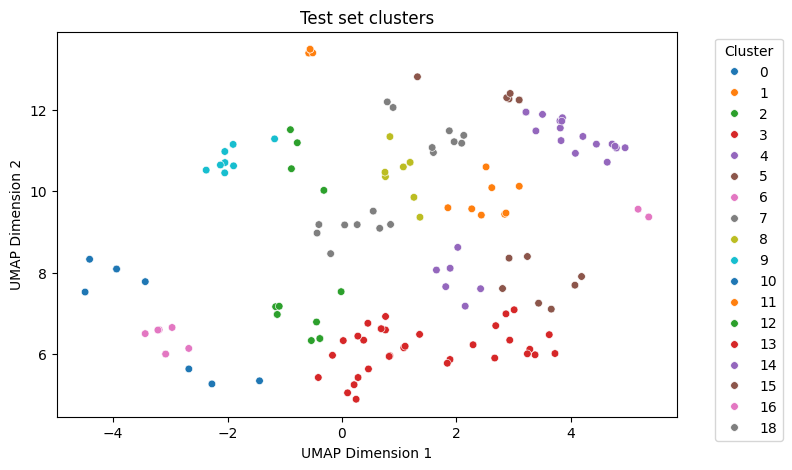

In [39]:
plot_clusters(
    embeddings=train_reduced_clean, 
    labels=train_labels, 
    title="Training set clusters"
)

plot_clusters(
    embeddings=val_reduced_clean, 
    labels=val_labels, 
    title="Validation set clusters"
)

plot_clusters(
    embeddings=test_reduced_clean, 
    labels=test_labels, 
    title="Test set clusters"
)


# <a id='toc6_'></a>[Task 2: Predict Classes](#toc0_)

Once you established the classes, we want to predict them. Build a small classification pipeline that uses the input (and optionally the drug_name) to predict the classes created in task 1. (N.B.: There are multiple ways how this can be and we again are looking to understand how you address this problem and evaluate your solution.)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

print(config)

X_train = train_reduced_clean
X_val = val_reduced_clean
X_test = test_reduced_clean

y_train = train_df_clean[f"best_clusters_{config.n_clusters}"].values
y_val = val_df_clean[f"best_clusters_{config.n_clusters}"].values
y_test = test_df_clean[f"best_clusters_{config.n_clusters}"].values

print("Cleaned Train:", X_train.shape)
print("Cleaned Val:", X_val.shape)
print("Cleaned Test:", X_test.shape)

Config(model_name='../distilroberta-base', batch_size=32, device='cpu', pooling_strategy='mean', random_state=27, n_components=2, n_neighbors=10, min_dist=0.05, metric='cosine', n_jobs=-1, clustering_method='kmeans', n_clusters=19, min_cluster_size=5, min_samples=5, kmeans_n_init=50, kmeans_max_iter=1000, hdbscan_metric='euclidean', hdbscan_min_cluster_size_range=range(2, 30), hdbscan_min_samples_range=[2, 3, 4, 5], cluster_range=range(5, 20))
Cleaned Train: (460, 2)
Cleaned Val: (117, 2)
Cleaned Test: (146, 2)


### <a id='toc6_1_1_'></a>[Check distributions](#toc0_)

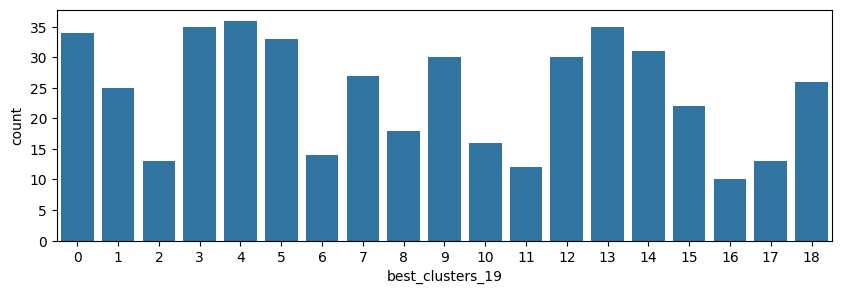

In [41]:
plt.figure(figsize=(10, 3))
sns.barplot(train_df_clean[f"best_clusters_{config.n_clusters}"].value_counts());
plt.show()

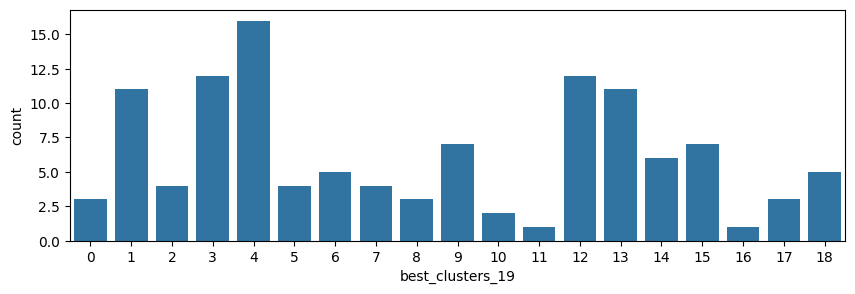

In [42]:
plt.figure(figsize=(10, 3))
sns.barplot(val_df_clean[f"best_clusters_{config.n_clusters}"].value_counts());
plt.show()

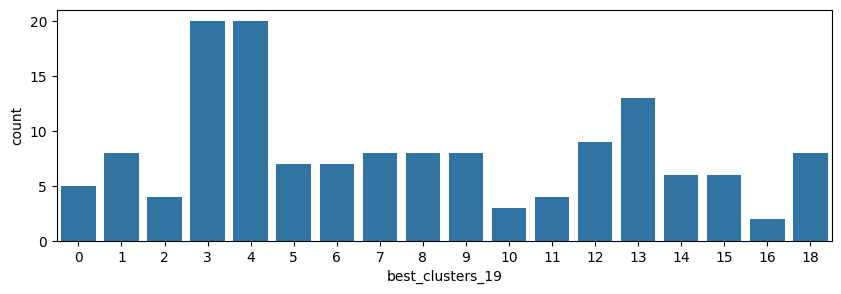

In [43]:
plt.figure(figsize=(10, 3))
sns.barplot(test_df_clean[f"best_clusters_{config.n_clusters}"].value_counts());
plt.show()

The data is imbalanced which we need to take into account in our modelling. Let's check teh distributions between training and validation sets to check if validation set is representative of teh train set.

In [44]:
train_cluster_dist = train_df_clean[f"best_clusters_{config.n_clusters}"].value_counts(normalize=True)
val_cluster_dist = val_df_clean[f"best_clusters_{config.n_clusters}"].value_counts(normalize=True)

comparison = pd.DataFrame({
    "Train Proportion": train_cluster_dist,
    "Validation Proportion": val_cluster_dist
}).fillna(0)

print(comparison)

                  Train Proportion  Validation Proportion
best_clusters_19                                         
0                         0.073913               0.025641
1                         0.054348               0.094017
2                         0.028261               0.034188
3                         0.076087               0.102564
4                         0.078261               0.136752
5                         0.071739               0.034188
6                         0.030435               0.042735
7                         0.058696               0.034188
8                         0.039130               0.025641
9                         0.065217               0.059829
10                        0.034783               0.017094
11                        0.026087               0.008547
12                        0.065217               0.102564
13                        0.076087               0.094017
14                        0.067391               0.051282
15            

Some clusters (0, 1, 4) for example are overrepresented in validation sets and some are underrepresented. There are different approaches for this. One approach is combining existing train and valid sets into 1 and split them again using stratified splitting based on cluster labels. Another approach is to upsample minority classes or use balanced weighting. There are some very small clusters so there is a high chance that the model will be able to predict them very well.

### <a id='toc6_1_2_'></a>[Modeling](#toc0_)

#### <a id='toc6_1_2_1_'></a>[Random Forest](#toc0_)

In [45]:
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

def train_model(X_train, y_train, X_test, y_test):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.random_state)

    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 15, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2"],
        "class_weight": ["balanced"]
    }

    outer_train_scores = []
    outer_test_scores = []
    best_params_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train)):
        print(f"\nOuter Fold {fold_idx + 1}...")

        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold = y_train[val_idx]

        # Inner cross-validation
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.random_state)
        
        # RandomizedSearchCV with inner cross-validation
        inner_search = RandomizedSearchCV(
            RandomForestClassifier(random_state=config.random_state),
            param_distributions=param_grid,
            n_iter=20,
            scoring="f1_macro",
            cv=inner_cv,
            random_state=config.random_state,
            n_jobs=-1
        )

        inner_search.fit(X_train_fold, y_train_fold)

        best_model = inner_search.best_estimator_
        best_params_list.append(inner_search.best_params_)

        y_train_pred = best_model.predict(X_train_fold)
        train_score = f1_score(y_train_fold, y_train_pred, average="weighted")
        outer_train_scores.append(train_score)

        y_val_pred = best_model.predict(X_val_fold)
        val_score = f1_score(y_val_fold, y_val_pred, average="weighted")
        outer_test_scores.append(val_score)
        
        print(f"Fold {fold_idx + 1} Train weighted f1: {train_score:.4f}")
        print(f"Fold {fold_idx + 1} Validation weighted f1: {val_score:.4f}")
        print(f"Best parameters for fold {fold_idx + 1}:", inner_search.best_params_)

    mean_val_score = np.mean(outer_test_scores)
    std_val_score = np.std(outer_test_scores)
    print(f"\nNested Cross-validation Summary:")
    print(f"Mean validation weighted f1: {mean_val_score:.4f} ± {std_val_score:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(outer_train_scores) + 1), outer_train_scores, label="Train weighted f1", marker="o")
    plt.plot(range(1, len(outer_test_scores) + 1), outer_test_scores, label="Validation weighted f1", marker="o")
    plt.title("Learning Curve: Weighted F1 Score")
    plt.xlabel("Outer Fold Number")
    plt.ylabel("Weighted F1 Score")
    plt.legend()
    plt.grid()
    plt.show()

    print("\nMost common best parameters across folds:")
    for param in param_grid.keys():
        param_values = [params[param] for params in best_params_list]
        most_common = max(set(param_values), key=param_values.count)
        print(f"{param}: {most_common}")

    # Use most common parameters for final model
    final_params = {}
    for param in param_grid.keys():
        param_values = [params[param] for params in best_params_list]
        final_params[param] = max(set(param_values), key=param_values.count)

    final_model = RandomForestClassifier(random_state=config.random_state, **final_params)
    final_model.fit(X_train, y_train)

    # Evaluate on test set
    y_test_pred = final_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print("\nTest Set Evaluation:")
    print(f"Test weighted f1: {test_f1:.4f}")
    print("\nClassification Report for Test Set:")
    print(classification_report(y_test, y_test_pred))

    return final_model, final_params

#### <a id='toc6_1_2_2_'></a>[Make the pipeline](#toc0_)

In [46]:
def run_full_pipeline(df, config, include_drug_names=False):
    """
    Run the complete pipeline from data splitting to model evaluation.

    Args:
        df (pd.DataFrame): Input dataframe with 'processed_adverse_events' and optionally 'drug_name'
        config (Config): Configuration object with all parameters
        include_drug_names (bool): Whether to include drug names in the model

    Returns:
        tuple: (final_model, final_params, cluster_model, performance_metrics)
    """
    # 1. Initial data split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=config.random_state
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.2, random_state=config.random_state
    )

    # Confirm splits are correct
    assert set(train_df.index).intersection(val_df.index) == set()
    assert set(test_df.index).intersection(val_df.index) == set()
    assert set(train_df.index).intersection(test_df.index) == set()

    # 2. Generate adverse event embeddings
    embedding_generator = EmbeddingGenerator(config)

    print("Generating embeddings...")
    train_embeddings = embedding_generator.generate_embeddings(train_df['processed_adverse_events'].tolist())
    val_embeddings = embedding_generator.generate_embeddings(val_df['processed_adverse_events'].tolist())
    test_embeddings = embedding_generator.generate_embeddings(test_df['processed_adverse_events'].tolist())
    
    # 3. Normalize embeddings
    train_norm = train_embeddings / np.linalg.norm(train_embeddings, axis=1)[:, np.newaxis]
    val_norm = val_embeddings / np.linalg.norm(val_embeddings, axis=1)[:, np.newaxis]
    test_norm = test_embeddings / np.linalg.norm(test_embeddings, axis=1)[:, np.newaxis]

    # 4. UMAP reduction
    umap = UMAP(
        n_components=config.n_components,
        n_neighbors=config.n_neighbors,
        min_dist=config.min_dist,
        metric=config.metric,
        random_state=config.random_state
    )

    print("Performing UMAP reduction...")
    train_reduced = umap.fit_transform(train_norm)
    val_reduced = umap.transform(val_norm)
    test_reduced = umap.transform(test_norm)

    # 5. Outlier detection
    iso_forest = IsolationForest(contamination=0.05, random_state=config.random_state)
    iso_forest.fit(train_reduced)
    
    train_inliers = iso_forest.predict(train_reduced) == 1
    val_inliers = iso_forest.predict(val_reduced) == 1
    test_inliers = iso_forest.predict(test_reduced) == 1
    
    train_reduced_clean = train_reduced[train_inliers]
    val_reduced_clean = val_reduced[val_inliers]
    test_reduced_clean = test_reduced[test_inliers]

    # Clean dataframes
    train_df_clean = train_df[train_inliers].copy()
    val_df_clean = val_df[val_inliers].copy()
    test_df_clean = test_df[test_inliers].copy()

    # 6. Optional: Process drug names
    if include_drug_names:
        print("Processing drug names...")
        # Generate drug embeddings
        train_drug_embeddings = embedding_generator.generate_embeddings(train_df_clean["drug_name"].tolist())
        val_drug_embeddings = embedding_generator.generate_embeddings(val_df_clean["drug_name"].tolist())
        test_drug_embeddings = embedding_generator.generate_embeddings(test_df_clean["drug_name"].tolist())

        # Normalize drug embeddings
        train_drug_norm = train_drug_embeddings / np.linalg.norm(train_drug_embeddings, axis=1)[:, np.newaxis]
        val_drug_norm = val_drug_embeddings / np.linalg.norm(val_drug_embeddings, axis=1)[:, np.newaxis]
        test_drug_norm = test_drug_embeddings / np.linalg.norm(test_drug_embeddings, axis=1)[:, np.newaxis]

        # UMAP reduction for drugs
        drug_umap = UMAP(
            n_components=config.n_components,
            n_neighbors=config.n_neighbors,
            min_dist=config.min_dist,
            metric=config.metric,
            random_state=config.random_state
        )

        train_drug_reduced = drug_umap.fit_transform(train_drug_norm)
        val_drug_reduced = drug_umap.transform(val_drug_norm)
        test_drug_reduced = drug_umap.transform(test_drug_norm)

        # Combine features
        train_reduced_clean = np.hstack([train_reduced_clean, train_drug_reduced])
        val_reduced_clean = np.hstack([val_reduced_clean, val_drug_reduced])
        test_reduced_clean = np.hstack([test_reduced_clean, test_drug_reduced])

    # 7. Perform clustering
    print("Performing clustering...")
    clustering_model, best_n_clusters, train_labels, val_labels, test_labels = perform_clustering(
        train_reduced_clean,
        val_reduced_clean,
        test_reduced_clean,
        config
    )

    # 8. Assign best_n_clusters to config
    print(f"Best number of clusters: {best_n_clusters}")
    config.n_clusters = best_n_clusters

    # 9. Assign cluster labels
    cluster_col = f"best_clusters_{config.n_clusters}"
    train_df_clean[cluster_col] = train_labels
    val_df_clean[cluster_col] = val_labels
    test_df_clean[cluster_col] = test_labels

    # 10. Train model
    print("Training final model...")
    X_train = train_reduced_clean
    y_train = train_df_clean[f"best_clusters_{config.n_clusters}"].values
    X_test = test_reduced_clean
    y_test = test_df_clean[f"best_clusters_{config.n_clusters}"].values

    final_model, final_params = train_model(X_train, y_train, X_test, y_test)
    
    # Collect models
    models = {
        'embedding_generator': embedding_generator,
        'umap_model': umap,                        
        'iso_forest': iso_forest,                  
        'clustering_model': clustering_model,      
        'final_model': final_model            
    }

    # Collect performance metrics
    performance_metrics = {
        'best_n_clusters': best_n_clusters,
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'train_df_shape': train_df_clean.shape,
        'test_df_shape': test_df_clean.shape,
    }

    return final_model, final_params, clustering_model, performance_metrics, models

#### <a id='toc6_1_2_3_'></a>[Without using drug names](#toc0_)

Generating embeddings...
Performing UMAP reduction...
Performing clustering...
Best number of clusters (KMeans): 19 with Silhouette Score: 0.5493
Best number of clusters: 19
Training final model...

Outer Fold 1...
Fold 1 Train weighted f1: 1.0000
Fold 1 Validation weighted f1: 0.9349
Best parameters for fold 1: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}

Outer Fold 2...
Fold 2 Train weighted f1: 1.0000
Fold 2 Validation weighted f1: 0.9671
Best parameters for fold 2: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced'}

Outer Fold 3...
Fold 3 Train weighted f1: 0.9946
Fold 3 Validation weighted f1: 0.9890
Best parameters for fold 3: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}

Outer Fold 4...
Fold 4 Train weighted f

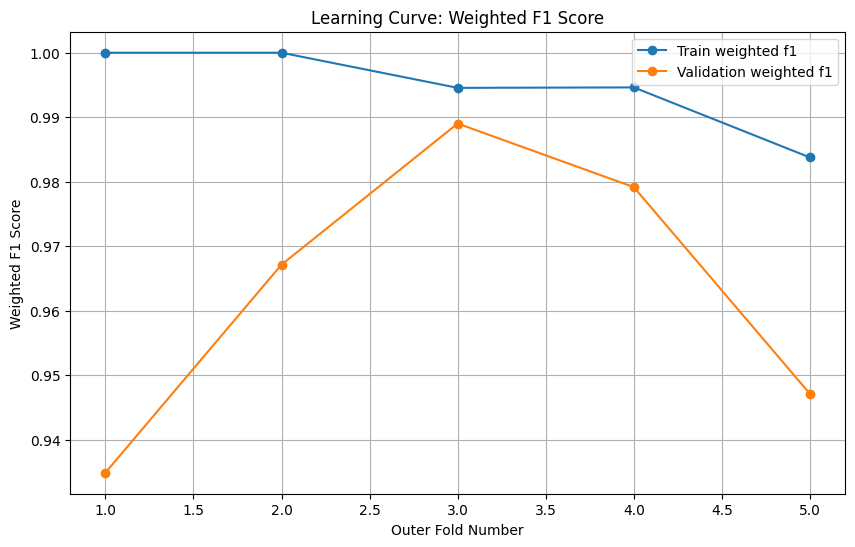


Most common best parameters across folds:
n_estimators: 100
max_depth: 20
min_samples_split: 5
min_samples_leaf: 5
max_features: log2
class_weight: balanced

Test Set Evaluation:
Test weighted f1: 0.8580

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      0.50      0.67         4
           3       0.83      0.75      0.79        20
           4       1.00      0.85      0.92        20
           5       1.00      0.71      0.83         7
           6       1.00      1.00      1.00         7
           7       0.88      0.88      0.88         8
           8       0.78      0.88      0.82         8
           9       0.89      1.00      0.94         8
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       0.50      0.56      0.53         9
 

In [47]:
final_model, final_params, clustering_model, performance_metrics, models = run_full_pipeline(df, config, include_drug_names=False)

#### <a id='toc6_1_2_4_'></a>[Using drug names](#toc0_)

Generating embeddings...
Performing UMAP reduction...
Processing drug names...
Performing clustering...
Best number of clusters (KMeans): 14 with Silhouette Score: 0.4985
Best number of clusters: 14
Training final model...

Outer Fold 1...
Fold 1 Train weighted f1: 1.0000
Fold 1 Validation weighted f1: 1.0000
Best parameters for fold 1: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}

Outer Fold 2...
Fold 2 Train weighted f1: 1.0000
Fold 2 Validation weighted f1: 0.9891
Best parameters for fold 2: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}

Outer Fold 3...
Fold 3 Train weighted f1: 1.0000
Fold 3 Validation weighted f1: 1.0000
Best parameters for fold 3: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}

Outer Fold 4...

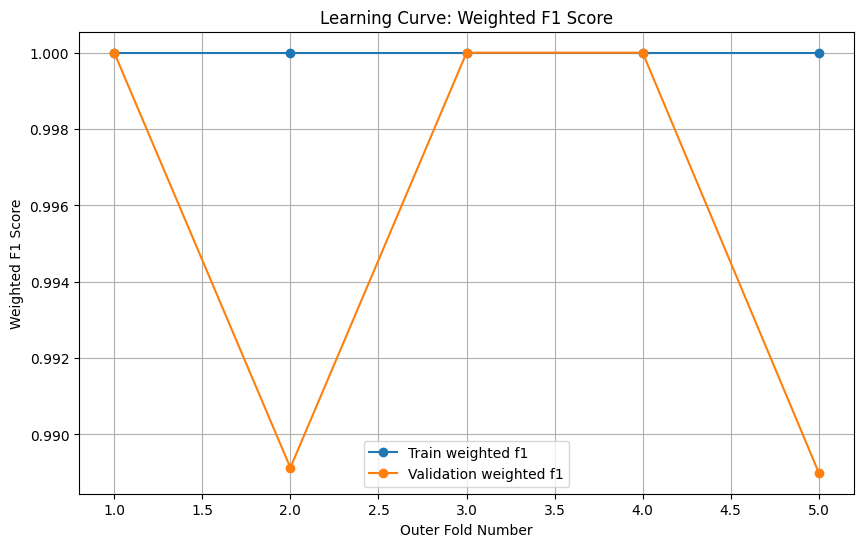


Most common best parameters across folds:
n_estimators: 200
max_depth: 20
min_samples_split: 2
min_samples_leaf: 1
max_features: log2
class_weight: balanced

Test Set Evaluation:
Test weighted f1: 0.9932

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        14
 

In [48]:
final_model, final_params, clustering_model, performance_metrics, models = run_full_pipeline(df, config, include_drug_names=True)

# <a id='toc7_'></a>[Model Performance Analysis](#toc0_)

#### <a id='toc7_1_1_1_'></a>[Without drug names](#toc0_)
The nested cross-validation results shows good performance. The learning curve suggests some overfitting, but not severe. Test score is 0.8580 vs train score of 0.9635 ± 0.0200. The model performs perfectly well on some classes (perfect F1 scores for 6 classes) while struggling with others (e.g., class 12: 0.53 F1-score), reflecting the challenge of imbalanced medical symptom data. The dimensionality reduction to 2D via UMAP helped create well-separated clusters, contributing to the overall good performance.

I tried SMOTE and splitting the data again on train + validation with stratification to mitigate for imbalanced data, but results were almost perfect so I decided to stick to this version which shows reasonable performance.

#### <a id='toc7_1_1_2_'></a>[With drug names](#toc0_)
Performance is perfect which is concerning. This suggests the model is learning drug names mostly and overfitting. Also it has lower silhouette score (0.4985 vs 0.5493 previously). This suggests the actual cluster separation is worse, despite better classification results. 

I would suggest using only adverse events, without drug names.

# <a id='toc8_'></a>[Future improvements](#toc0_)
- Optimise UMAP parameters
- Test different dimensionality reduction techniques (t-SNE, PCA)
- Experiment with different clustering algorithms (DBSCAN, Hierarchical)
- Investigate ways to balance the influence of drug names vs adverse events
- Include temporal information about when adverse events occur
- I tried BioBERT instead of RoBERTa, but wanted to keep it as general as possible so I stayed with RoBERTa. This can be easily adjusted in config anyway so it would be good to compare different models.
- Explain predictions
- Clean up the code and simplify how Config is being used
- Production ready code and test inference code further

# <a id='toc9_'></a>[Inference example](#toc0_)

In [49]:
import pickle
import joblib

def save_models(models_dict, config, include_drug_names, save_path='../models/'):
    """Save all models and configuration"""
    os.makedirs(save_path, exist_ok=True)

    joblib.dump(models_dict['embedding_generator'], f'{save_path}embedding_generator.joblib')
    joblib.dump(models_dict['umap_model'], f'{save_path}umap_model.joblib')
    joblib.dump(models_dict['drug_umap_model'], f'{save_path}drug_umap_model.joblib')
    joblib.dump(models_dict['iso_forest'], f'{save_path}iso_forest.joblib')
    joblib.dump(models_dict['clustering_model'], f'{save_path}clustering_model.joblib')
    joblib.dump(models_dict['final_model'], f'{save_path}final_model.joblib')

    joblib.dump({
        'include_drug_names': include_drug_names
    }, f'{save_path}config.joblib')


def load_models(load_path='../models/'):
    """Load all models and configuration"""
    models = {
        'embedding_generator': joblib.load(f'{load_path}embedding_generator.joblib'),
        'umap_model': joblib.load(f'{load_path}umap_model.joblib'),
        'drug_umap_model': joblib.load(f'{load_path}drug_umap_model.joblib'),
        'iso_forest': joblib.load(f'{load_path}iso_forest.joblib'),
        'clustering_model': joblib.load(f'{load_path}clustering_model.joblib'),
        'final_model': joblib.load(f'{load_path}final_model.joblib')
    }
    config = joblib.load(f'{load_path}config.joblib')
    return models, config['include_drug_names']


def predict_new_cases(new_data, config, embedding_generator, umap_model, drug_umap_model, 
                     iso_forest, clustering_model, final_model, include_drug_names=False):
    """Make predictions with option to use drug names"""
    embeddings = embedding_generator.generate_embeddings(new_data['processed_adverse_events'].tolist())
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    reduced = umap_model.transform(embeddings_norm)
    
    if include_drug_names and 'drug_name' in new_data.columns:
        drug_embeddings = embedding_generator.generate_embeddings(new_data["drug_name"].tolist())
        drug_norm = drug_embeddings / np.linalg.norm(drug_embeddings, axis=1)[:, np.newaxis]
        drug_reduced = drug_umap_model.transform(drug_norm)

        reduced = np.hstack([reduced, drug_reduced])

    inliers = iso_forest.predict(reduced) == 1
    reduced_clean = reduced[inliers]

    predictions = final_model.predict(reduced_clean)
    
    return predictions, inliers


def make_predictions(new_data, use_drug_names=False):
    """Make predictions with option to use drug names"""
    models, saved_drug_names_config = load_models()

    if use_drug_names != saved_drug_names_config:
        raise ValueError(f"Model was trained with include_drug_names={saved_drug_names_config}, "
                       f"but prediction was attempted with use_drug_names={use_drug_names}")
    
    new_predictions, is_inlier = predict_new_cases(
        new_data=new_data,
        config=config,
        include_drug_names=use_drug_names,
        **models
    )
    
    valid_predictions = new_predictions[is_inlier]
    
    results = pd.DataFrame({
        'adverse_event': new_data['processed_adverse_events'],
        'predicted_cluster': None,
        'is_valid': is_inlier
    })
    
    results.loc[is_inlier, 'predicted_cluster'] = valid_predictions
    
    return results

In [50]:
models_to_save = {
    'embedding_generator': embedding_generator,
    'umap_model': umap,
    'drug_umap_model': None,
    'iso_forest': iso_forest,
    'clustering_model': clustering_model,
    'final_model': final_model
}

save_models(models_to_save, config, include_drug_names=False) 

In [51]:
# Run this after trained model with use_drug_names=False
# new_cases_df = pd.DataFrame({
#     'processed_adverse_events': [
#         'severe headache nausea',
#         'skin rash itching',
#         'muscle pain weakness'
#     ],
#     'drug_name': [
#         'drug_a',
#         'drug_b',
#         'drug_c'
#     ]
# })

# results = make_predictions(new_cases_df, use_drug_names=False)
# results